# Spark Logistic Regression
This notebook reads the data splits from `04_create_data_splits` to apply a Logistic Regression model in Python and a from-scratch Logistic Regression model in Spark (with a homemade implementation of Gradient Descent).

See the `01_food_inspections_data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  See the `02_census_data_prep` notebook for the US Census API terms of use.

### Analysis and Models in this Notebook

- Simple Logistic Regression model using scikit-learn
- From-scratch Logistic Regression model using homemade implementation of Gradient Descent
- Spark MLlib Logistic Regression

### Set Global Seed

In [1]:
SEED = 666

In [2]:
!pip install findspark

  Using cached https://files.pythonhosted.org/packages/b1/c8/e6e1f6a303ae5122dc28d131b5a67c5eb87cbf8f7ac5b9f87764ea1b1e1e/findspark-1.3.0-py2.py3-none-any.whl


In [3]:
import os

# Make sure you call it before importing pyspark
import findspark
findspark.init()

# Defining the python version to use on the workers
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

### Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

from pyspark import SparkContext
from pyspark.sql.types import FloatType, StructType, StructField, LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression

import l2_regularized_logistic_regression as nplr

### Load Sklearn Data and Create Train and Test Splits

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

In [6]:
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Scale Train and Test Sets

In [7]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)

### Check Performance of scikit-learn Logistic Regression with No Regularization
Setting the regularization parameter to `1e8` we get effectively no regularization, as in the statsmodel API Logit model.  See this issue for details: https://github.com/scikit-learn/scikit-learn/issues/6738

In [8]:
sklearn_clf = SklearnLogisticRegression(C=1e8, # https://github.com/scikit-learn/scikit-learn/issues/6738
                                        penalty='l2',
                                        solver='liblinear',
                                        fit_intercept=True,
                                        max_iter=1000)

In [9]:
%%time
sklearn_clf.fit(X_train_scaled, y_train)

CPU times: user 8.42 ms, sys: 99 µs, total: 8.52 ms
Wall time: 7.49 ms


LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Compute Accuracy at 0.5 Threshold

In [10]:
y_prob = sklearn_clf.predict_proba(X_test_scaled)[:, 1]

In [11]:
y_pred = [1 if x > 0.5 else 0 for x in y_prob]
np.mean(y_test == y_pred)

0.9440559440559441

### Initialize Spark

In [12]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('lr').getOrCreate()

### Logistic Regression Algorithm for Spark RDD
M. Zaharia, M. Chowdhury, T. Das, A. Dave, J. Ma,
M. McCauley, M. J. Franklin, S. Shenker, and I. Stoica. Resilient distributed datasets: A fault-tolerant
abstraction for in-memory cluster computing.
In Proceedings of NSDI, pages 15–28, 2012.

### Create new X and Ys for From-Scratch Training

In [13]:
Xt = X_train_scaled.copy()
Xt_test = X_test_scaled.copy()
yt = nplr.transform_target(y_train)
yt_test = nplr.transform_target(y_test)

### Training Functions

In [14]:
def spark_lr_grad(d):
    
    import numpy as np
    
    x = np.array(d.x)
    y = d.y
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [15]:
def spark_lr_grad_descent(w, samples, n, learning_rate, n_iter):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
        gradient = samples.map(spark_lr_grad).reduce(lambda a, b: a + b)
        w -= learning_rate * gradient * 1/n
        ws.append(w.copy())
        
    return ws

### Create a Spark Dataframe of X Vectors and y Targets
Transform the target variable to [1, -1] instead of [1, 0].

In [16]:
pd_df = pd.DataFrame(yt, columns=['y'])
pd_df['x'] = Xt.tolist()
df = spark.createDataFrame(pd_df)

### Initialize Parameters

In [ ]:
samples = df.rdd
samples.cache()

In [17]:
w = np.zeros(Xt.shape[1])
# w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = samples.count()
learning_rate = 1.0
n_iter = 30

### Run Gradient Descent

In [18]:
ws = spark_lr_grad_descent(w, samples, n, learning_rate, n_iter)

### Predict

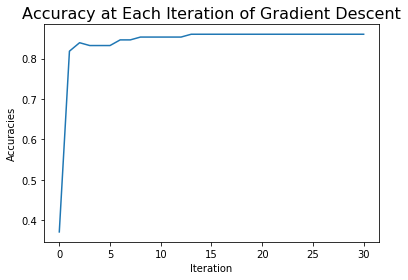

In [19]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Raw Python Version
Based on https://github.com/jstremme/l2-regularized-logistic-regression but without regularization and vectorization of matrix operations.  Instead `py_lr_grad_descent` computes the gradient on each sample sequentially, unlike spark which will compute the gradient on each sample but in parallel.

### Training Functions

In [20]:
def py_lr_grad(w, x, y):
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [21]:
def py_lr_grad_descent(w, X, y, n, learning_rate, n_iter, v):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
    
        gradient_total = 0
        for j in range(0, n, 1): # replaced with map and reduce in spark
            x_j = X[j]
            y_j = y[j]
            gradient_total += py_lr_grad(w, x_j, y_j)

        w -= learning_rate * gradient_total * 1/n
        ws.append(w.copy())
        
        if v:
            print('Objective function at iteration {}: {}'.format(i, nplr.obj(X, y, beta=w, lambda_penalty=0)))
    
    return ws

### Initialized_parameters

In [22]:
w = np.zeros(Xt.shape[1])
# w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = Xt.shape[0]
learning_rate = 1.0
n_iter = 30
v = 1

### Run Gradient Descent

In [23]:
ws = py_lr_grad_descent(w, Xt, yt, n, learning_rate, n_iter, v)

Objective function at iteration 0: 0.677174318664879
Objective function at iteration 1: 0.6622970544435027
Objective function at iteration 2: 0.6483982331886103
Objective function at iteration 3: 0.6353973591780903
Objective function at iteration 4: 0.6232231064511172
Objective function at iteration 5: 0.6118094673831423
Objective function at iteration 6: 0.6010952837856287
Objective function at iteration 7: 0.591024149228201
Objective function at iteration 8: 0.581544268825149
Objective function at iteration 9: 0.5726082467603322
Objective function at iteration 10: 0.5641728229169003
Objective function at iteration 11: 0.5561985814564777
Objective function at iteration 12: 0.5486496490572195
Objective function at iteration 13: 0.5414933953900091
Objective function at iteration 14: 0.5347001442510202
Objective function at iteration 15: 0.5282429006015229
Objective function at iteration 16: 0.5220970964457526
Objective function at iteration 17: 0.5162403568345498
Objective function at i

### Predict

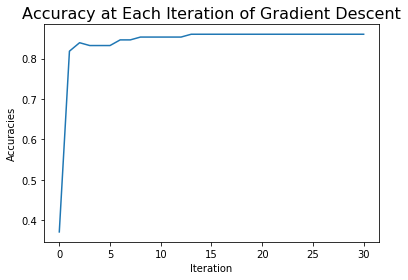

In [24]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Parallelized Numpy Version.
Implementation from https://github.com/jstremme/l2-regularized-logistic-regression.  

### Run Gradient Descent

In [25]:
ws = nplr.l2_log_reg(Xt, yt, lambda_penalty=0, eps=0.001, v=0)

### Predict

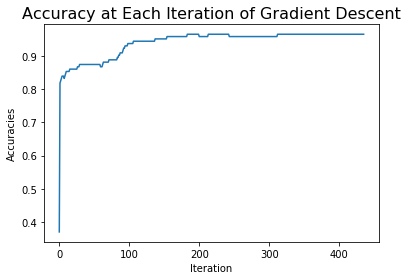

In [26]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Spark MLlib Version

In [27]:
train_df = spark.createDataFrame(nplr.to_df_with_class(X_train_scaled, y_train))
test_df = spark.createDataFrame(nplr.to_df_with_class(X_test_scaled, y_test))
target_column = 'class'

In [28]:
to_assemble = [item for item in train_df.columns if item != target_column]
assembler = VectorAssembler(inputCols=to_assemble, outputCol='features')
train_vector = assembler.transform(train_df)
test_vector = assembler.transform(test_df)

In [ ]:
train_vector.cache().count()

In [29]:
lr = SparkLogisticRegression(labelCol=target_column, featuresCol='features', regParam=0,
                             tol=0.001, standardization=False, fitIntercept=True)

In [30]:
%%time
lr = lr.fit(train_vector)

CPU times: user 64.5 ms, sys: 24.8 ms, total: 89.3 ms
Wall time: 13.4 s


In [31]:
y_pred = lr.transform(test_vector).select('prediction').rdd.map(lambda x: x.prediction).collect()
np.mean(y_test == y_pred)

0.951048951048951